In [1]:
%load_ext lab_black

# TODOs

## Moving:
- Move queue
    - A* pathfinding with weights based on move_cost
    - Add high cost where another bot will collide 
        - But position of other bots changes ... 
        - Maybe first just increase cose of entire path?
        - Can bots switch position?
        - Maybe A*, evaluate collisions, if collision, add cost to collision point and repeat until max repeats
        - Cost of collision decrease with distance (i.e. things more likely to change in future anyway)
            - Still want fairly high cost since better not to change work queue
 
- Avoid collisions
    - Record trajectory of all units
        - Keep light/heavy enemy/friendly separate (heavies should only avoid heavies for example)
        - If mining add X turns at that location
    - Ensure no collisions within X turns, otherwise change route
    

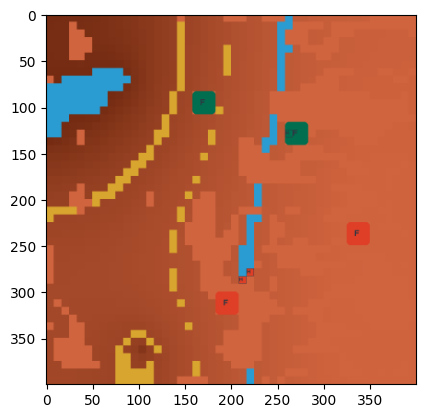

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from luxai2022 import LuxAI2022
from util import get_test_env, game_state_from_env, show_env
from util import UP, DOWN, LEFT, RIGHT, CENTER, ICE, ORE, METAL, POWER, WATER
from util import path_to_actions, actions_to_path


env = get_test_env()
game_state = game_state_from_env(env)
rend = env.render("rgb_array")
# plt.imshow(
#     np.transpose(rend, axes=[1, 0, 2])
# )  # Game state stores transposed, so for comparison sake, plot transposed
plt.imshow(
    rend
)  # Game state stores transposed, so for comparison sake, plot transposed

Text(0.5, 1.0, 'rubble')

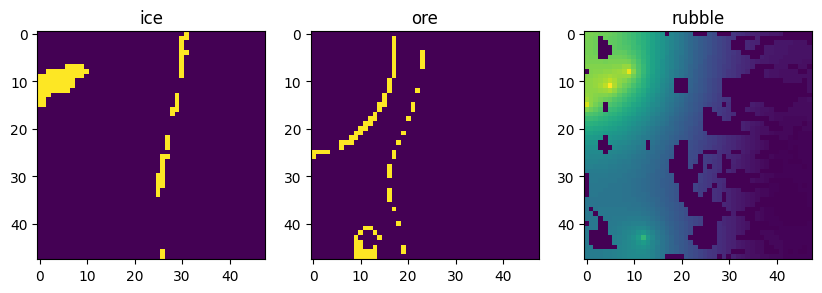

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(game_state.board.ice.T)
axs[1].imshow(game_state.board.ore.T)
axs[2].imshow(game_state.board.rubble.T)
axs[0].set_title("ice")
axs[1].set_title("ore")
axs[2].set_title("rubble")
# game_state.units["player_0"]["unit_5"]

In [4]:
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

In [5]:
# %%timeit
matrix_map = game_state.board.rubble.T.copy()
matrix_map += 10
start = [0, 0]
end = [15, 15]
# Time ~4us

In [6]:
# %%timeit
grid = Grid(matrix=matrix_map)
# Time ~6ms

In [7]:
# %%timeit
start_ = grid.node(*start)
end_ = grid.node(*end)
# Time ~1us

In [8]:
# %%timeit
finder = AStarFinder()
path, runs = finder.find_path(start_, end_, grid)
path = np.array(path)
# Time ~ 15us

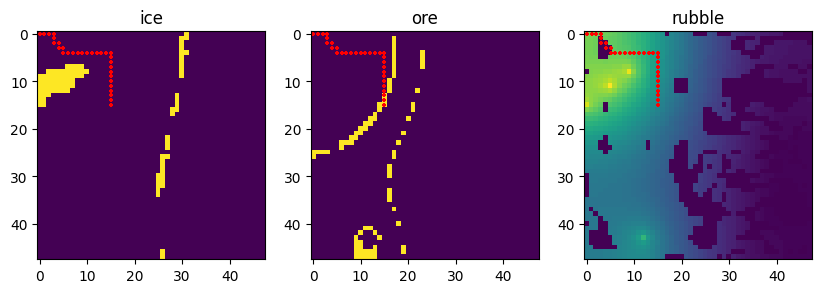

In [9]:
for ax in axs:
    ax.scatter(path[:, 0], path[:, 1], marker="+", s=10, c="r")
fig

In [10]:
from util import PathFinder

start = [0, 0]
end = [45, 45]
cost_map = game_state.board.rubble.T.copy() + 10


path_finder = PathFinder(cost_map)
path = path_finder.path(start, end)

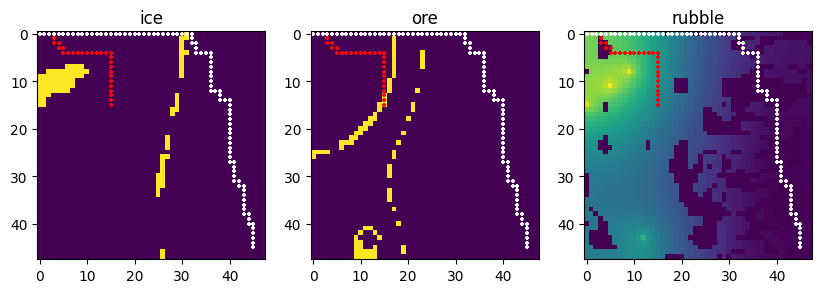

In [11]:
for ax in axs:
    ax.scatter(path[:, 0], path[:, 1], marker="+", s=10, c="white")
fig

## Figure out how to avoid collisions

In [12]:
game_state.units["player_0"].keys()

dict_keys(['unit_4', 'unit_5'])

player_0 unit_4 -- Pos: [25 34]
player_0 unit_5 -- Pos: [26 33]


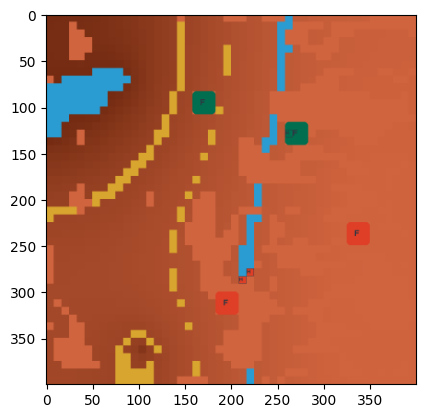

In [13]:
env = get_test_env()

rgb_array = env.render("rgb_array")
plt.imshow(rgb_array)


# env.render('rgb_array')
def _units(env):
    game_state = game_state_from_env(env)
    units = [game_state.units["player_0"][k] for k in ["unit_4", "unit_5"]]
    return units


units = _units(env)
for unit in units:
    print(f"{unit.agent_id} {unit.unit_id} -- Pos: {unit.pos}")

### Let's see if bots can switch positions

In [14]:
env = get_test_env()
game_state = game_state_from_env(env)

units = _units(env)
u4 = units[0]
u5 = units[1]

# First get the two units next to each other
actions = {
    "player_0": {
        u5.unit_id: [u5.move(DOWN)],
    },
    "player_1": {},
}

obs, rews, dones, infos = env.step(actions)
_ = show_env(env)

In [15]:
# Store up some energy
for i in range(5):
    actions = {
        "player_0": {},
        "player_1": {},
    }
    obs, rews, dones, infos = env.step(actions)

# Now try switch their positions
units = _units(env)
for unit in units:
    print(f"{unit.agent_id} {unit.unit_id} -- Pos: {unit.pos}")
actions = {
    "player_0": {
        u4.unit_id: [u4.move(RIGHT)],
        u5.unit_id: [u5.move(LEFT)],
    },
    "player_1": {},
}

obs, rews, dones, infos = env.step(actions)
_ = show_env(env)

units = _units(env)
for unit in units:
    print(f"{unit.agent_id} {unit.unit_id} -- Pos: {unit.pos}")

player_0 unit_4 -- Pos: [25 34]
player_0 unit_5 -- Pos: [26 34]
player_0 unit_4 -- Pos: [26 34]
player_0 unit_5 -- Pos: [25 34]


**Success -- Units switched position**

### Test giving path of actions to unit
- Assuming unit has enough energy for all actions
- Assuming no collisions

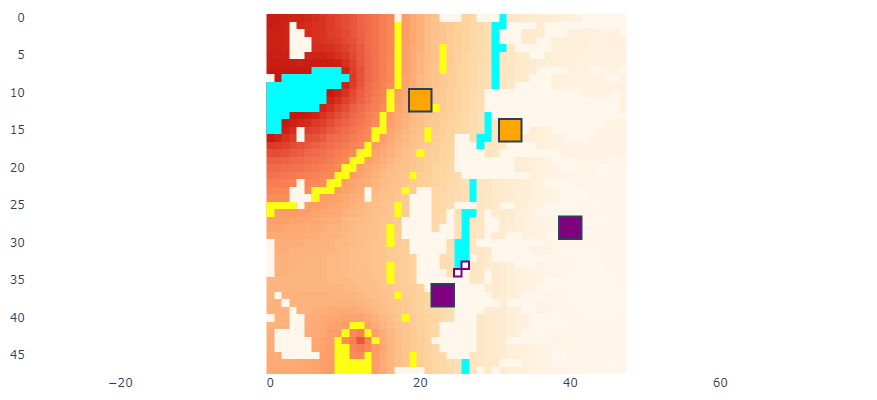

In [69]:
from matplotlib import colors
from lux.kit import GameState
from luxai2022.unit import UnitType
import plotly.graph_objects as go
import re
from matplotlib.patches import Rectangle

from util import show_env, mpl_plot_path, plotly_plot_path
import util

env = get_test_env()
game_state = game_state_from_env(env)
units = _units(env)
unit = units[0]

fig = show_env(env, mode="plotly")
fig.show()

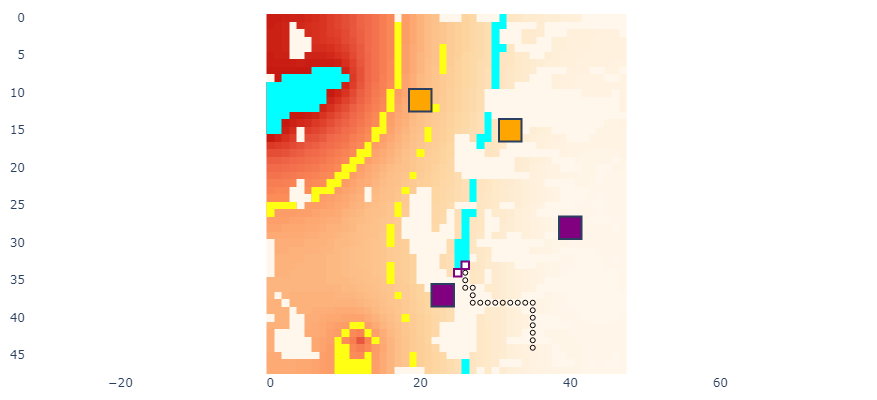

In [70]:
# Cost map for heavy units
cost_map = game_state.board.rubble.T.copy() + 10

pf = PathFinder(cost_map)
path = pf.path(unit.pos, [p + 10 for p in unit.pos])
fig = show_env(env)

plotly_plot_path(fig, path)

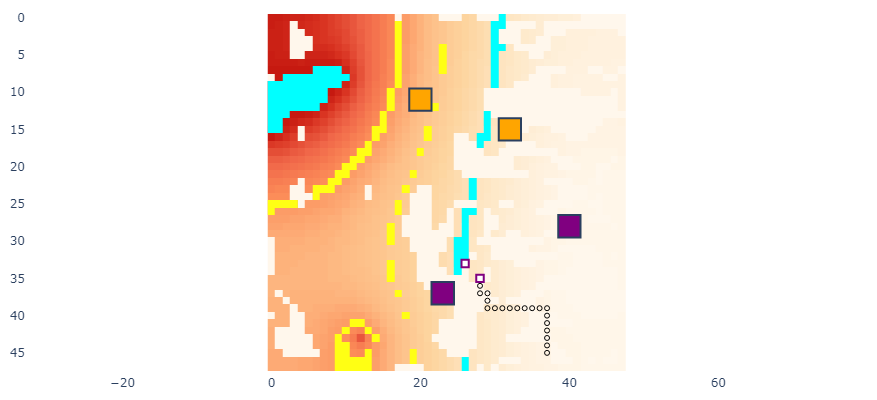

In [74]:
actions = {
    "player_0": {
        unit.unit_id: path_to_actions(unit, path),
    },
    "player_1": {},
}

obs, rews, dones, infos = env.step(actions)
fig = show_env(env)
fig

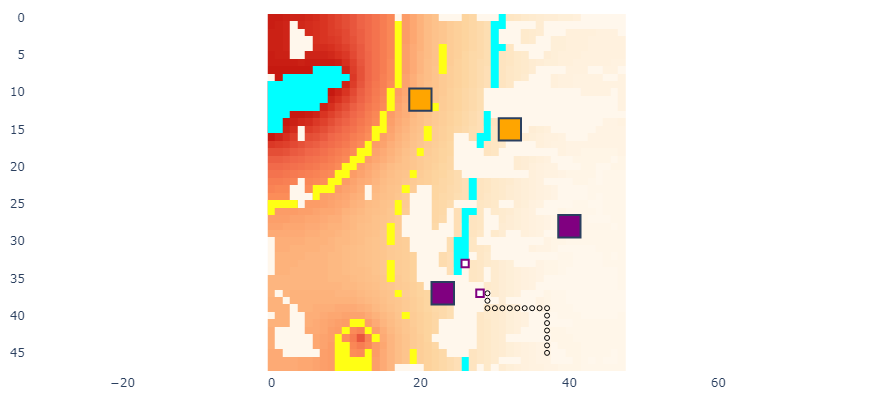

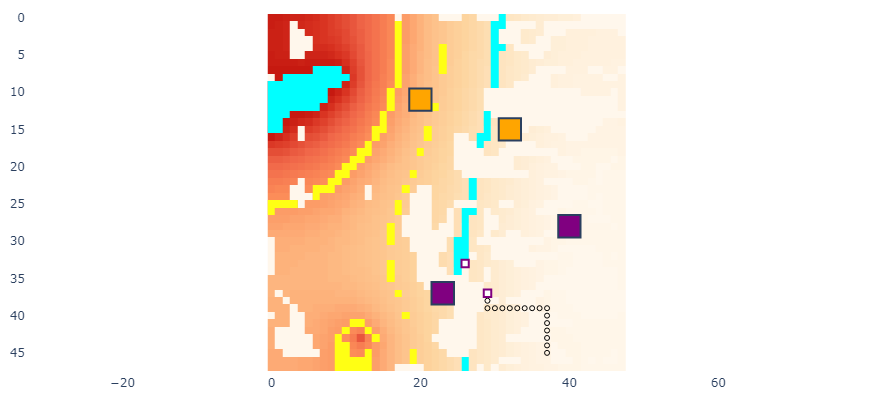

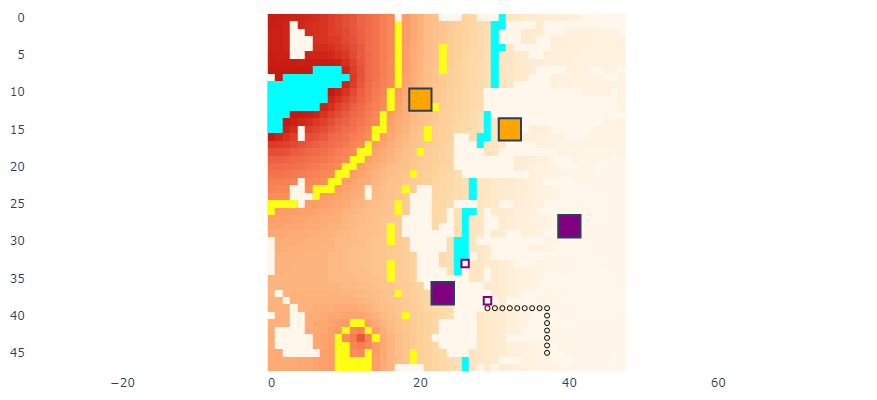

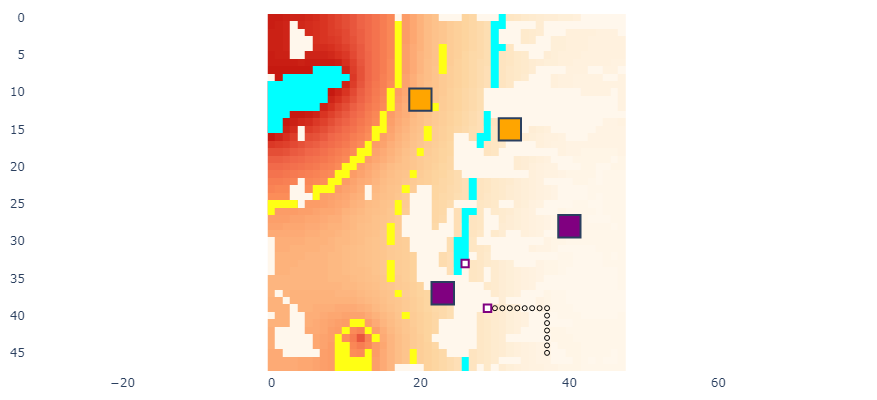

In [76]:
actions = {
    "player_0": {},
    "player_1": {},
}

figs = []
for i in range(4):
    obs, rews, dones, infos = env.step(actions)
    figs.append(show_env(env))
for fig in figs:
    fig.show()